In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

import scipy.stats as stats
# from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
raw_data = pd.read_csv('./2020 PPP Dataset/PPP Train ALL.csv')
raw_data.head()

,Unnamed: 0,BusinessType,CD,City,DateApproved,Gender,JobsRetained,Lender,LoanRange,NAICSCode,NonProfit,RaceEthnicity,State,Veteran,Zip,Industry,Index
0,0,Independent Contractors,CA - 49,LA JOLLA,04/30/2020,Unanswered,1.0,"U.S. Bank, National Association",$16300-27300,531210.0,N,Unanswered,CA,Unanswered,92037.0,Offices of Real Estate Agents and Brokers,1026947
1,1,Limited Liability Company(LLC),CA - 39,BREA,04/30/2020,Male Owned,4.0,"Bank of America, National Association",$7964-16300,423490.0,N,Unanswered,CA,Non-Veteran,92821.0,Other Professional Equipment and Supplies Merc...,1143280
2,2,Limited Liability Company(LLC),MI - 08,ROCHESTER HILLS,04/06/2020,Unanswered,208.0,Oxford Bank,$2-5 million,541612.0,N,Unanswered,MI,Unanswered,48309.0,Human Resources Consulting Services,286838
3,3,Independent Contractors,PA - 01,PHILADELPHIA,06/24/2020,Male Owned,1.0,Sun FCU,$0-7964,541430.0,N,White,PA,Unanswered,19123.0,Graphic Design Services,3727822
4,4,Sole Proprietorship,TX - 30,DALLAS,04/15/2020,Unanswered,10.0,"Texas Capital Bank, National Association",$56313-150000,522291.0,N,Unanswered,TX,Unanswered,75223.0,Consumer Lending,3960482


In [3]:
raw_data.shape

(3966377, 17)

In [4]:
raw_data = raw_data.drop(columns=['Unnamed: 0', 'Index'], axis=1)

In [5]:
raw_data[raw_data['NAICSCode'].isna()]

,BusinessType,CD,City,DateApproved,Gender,JobsRetained,Lender,LoanRange,NAICSCode,NonProfit,RaceEthnicity,State,Veteran,Zip,Industry


In [6]:
data = raw_data.copy()
data['BusinessType'] = raw_data['BusinessType'].fillna('Other_BT')
data['City'] = raw_data['City'].fillna('Other_City')
data['Zip'] = raw_data['Zip'].fillna('Other').astype(str)
data['NAICSCode'] = raw_data['NAICSCode'].astype(str)

In [7]:
# Split loan range column
data['Loan_min'] = data['LoanRange'].map({
    '$16300-27300': 16300, '$7964-16300': 7964, '$0-7964': 0, '$56313-150000':56313,
       '$27300-56313': 27300, '$150,000-350,000': 150000, '$350,000-1 million':350000,
       '$1-2 million': 1000000, '$2-5 million': 2000000, '$5-10 million': 5000000
})

data['Loan_max'] = data['LoanRange'].map({
    '$16300-27300': 27300, '$7964-16300': 16300, '$0-7964': 7964, '$56313-150000':150000,
       '$27300-56313': 56313, '$150,000-350,000': 350000, '$350,000-1 million':1000000,
       '$1-2 million': 2000000, '$2-5 million': 5000000, '$5-10 million': 10000000
})

In [8]:
data.describe(include='all')

,BusinessType,CD,City,DateApproved,Gender,JobsRetained,Lender,LoanRange,NAICSCode,NonProfit,RaceEthnicity,State,Veteran,Zip,Industry,Loan_min,Loan_max
count,3966377,3966377,3966377,3966377,3966377,3.966377e+06,3966377,3966377,3966377,3966377,3966377,3966377,3966377,3966377,3966377,3.966377e+06,3.966377e+06
unique,18,525,33773,79,3,NaN,4858,10,1057,2,9,51,3,35635,1057,NaN,NaN
top,Corporation,TX - 02,NEW YORK,04/28/2020,Unanswered,NaN,"Bank of America, National Association",$56313-150000,722511.0,N,Unanswered,CA,Unanswered,10001.0,Full-Service Restaurants,NaN,NaN
freq,1149395,27714,47649,373702,3038019,NaN,269464,691621,146877,3813123,3507995,454229,3337009,3973,146877,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.139693e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.293243e+04,1.753559e+05
std,NaN,NaN,NaN,NaN,NaN,3.262006e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.477068e+05,5.570224e+05
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,7.964000e+03
25%,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.964000e+03,1.630000e+04
50%,NaN,NaN,NaN,NaN,NaN,3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.630000e+04,2.730000e+04
75%,NaN,NaN,NaN,NaN,NaN,9.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.631300e+04,1.500000e+05


In [9]:
set(data['Loan_max'] - data['Loan_min'])

{7964, 8336, 11000, 29013, 93687, 200000, 650000, 1000000, 3000000, 5000000}

In [10]:
upper_quantile = raw_data['JobsRetained'].quantile(0.95)
lower_quantile = raw_data['JobsRetained'].quantile(0.05)
lower_quantile, upper_quantile

(0.0, 44.0)

In [11]:
data = data[data['JobsRetained'] < upper_quantile]
data = data[data['JobsRetained'] > lower_quantile]
data['JobsRetained'] = data['JobsRetained'].astype(int)

In [12]:
data.describe(include='all')

,BusinessType,CD,City,DateApproved,Gender,JobsRetained,Lender,LoanRange,NAICSCode,NonProfit,RaceEthnicity,State,Veteran,Zip,Industry,Loan_min,Loan_max
count,3281982,3281982,3281982,3281982,3281982,3.281982e+06,3281982,3281982,3281982,3281982,3281982,3281982,3281982,3281982,3281982,3.281982e+06,3.281982e+06
unique,18,513,30604,79,3,NaN,4810,10,1057,2,9,51,3,35027,1057,NaN,NaN
top,Limited Liability Company(LLC),CA - 33,NEW YORK,04/28/2020,Unanswered,NaN,"Bank of America, National Association",$56313-150000,722511.0,N,Unanswered,CA,Unanswered,10001.0,Full-Service Restaurants,NaN,NaN
freq,961544,22513,38257,319359,2470832,NaN,257229,614008,114588,3164121,2872072,374060,2737437,3105,114588,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,6.939753e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.039352e+04,9.932918e+04
std,NaN,NaN,NaN,NaN,NaN,8.198909e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.226396e+04,1.852441e+05
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,7.964000e+03
25%,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.964000e+03,1.630000e+04
50%,NaN,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.630000e+04,2.730000e+04
75%,NaN,NaN,NaN,NaN,NaN,9.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.631300e+04,1.500000e+05


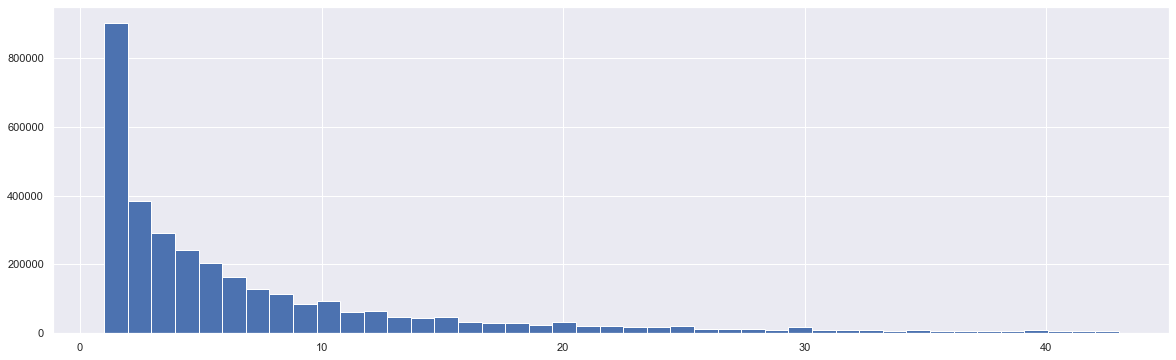

In [13]:
plt.figure(figsize=(20, 6))
plt.hist(data['JobsRetained'].astype(int), bins=len(data['JobsRetained'].unique()))
plt.show()

In [14]:
average_count_of_each_target = data[data['JobsRetained'] == 7].count()[0] # because mean=7
average_count_of_each_target

128862

In [15]:
# Balance data
data_balanced = pd.DataFrame(columns=data.columns)
for val in data['JobsRetained'].unique():
    temp_data = data[data['JobsRetained'] == val].copy()
    if temp_data.count()[0] > average_count_of_each_target:
        temp_data = temp_data[:average_count_of_each_target]
    data_balanced = pd.concat([data_balanced, temp_data], axis=0)
data_balanced['JobsRetained'] = data_balanced['JobsRetained'].astype(int)

In [16]:
data_balanced['Loan_min'] = data_balanced['Loan_min'].astype(float)
data_balanced['Loan_max'] = data_balanced['Loan_max'].astype(float)
data_balanced.describe(include='all')

,BusinessType,CD,City,DateApproved,Gender,JobsRetained,Lender,LoanRange,NAICSCode,NonProfit,RaceEthnicity,State,Veteran,Zip,Industry,Loan_min,Loan_max
count,1869665,1869665,1869665,1869665,1869665,1.869665e+06,1869665,1869665,1869665,1869665,1869665,1869665,1869665,1869665,1869665,1.869665e+06,1.869665e+06
unique,18,496,24577,79,3,NaN,4759,10,1057,2,8,51,3,32972,1057,NaN,NaN
top,Corporation,TX - 02,NEW YORK,04/28/2020,Unanswered,NaN,"Bank of America, National Association",$56313-150000,722511.0,N,Unanswered,CA,Unanswered,10001.0,Full-Service Restaurants,NaN,NaN
freq,635637,12741,21574,174491,1351840,NaN,142667,557725,99079,1786595,1605687,218460,1507334,1924,99079,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.068310e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.125564e+04,1.526752e+05
std,NaN,NaN,NaN,NaN,NaN,9.167473e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.755541e+04,2.262054e+05
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,7.964000e+03
25%,NaN,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.630000e+04,2.730000e+04
50%,NaN,NaN,NaN,NaN,NaN,8.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.730000e+04,5.631300e+04
75%,NaN,NaN,NaN,NaN,NaN,1.400000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.631300e+04,1.500000e+05


In [17]:
data = data_balanced.copy()

del data_balanced

In [18]:
# Find out normal distribution of target
data['JobsRetained'].describe()

count    1.869665e+06
mean     1.068310e+01
std      9.167473e+00
min      1.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      4.300000e+01
Name: JobsRetained, dtype: float64

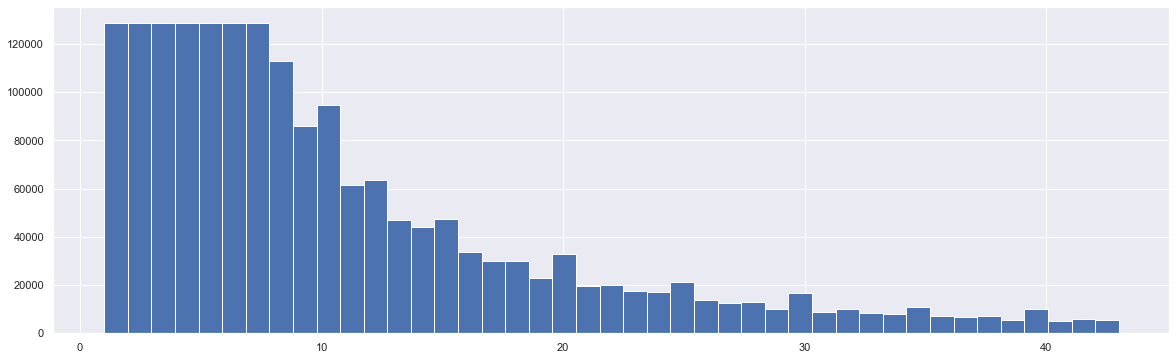

In [19]:
plt.figure(figsize=(20, 6))
plt.hist(data['JobsRetained'].astype(int), bins=len(data['JobsRetained'].unique()))
plt.show()

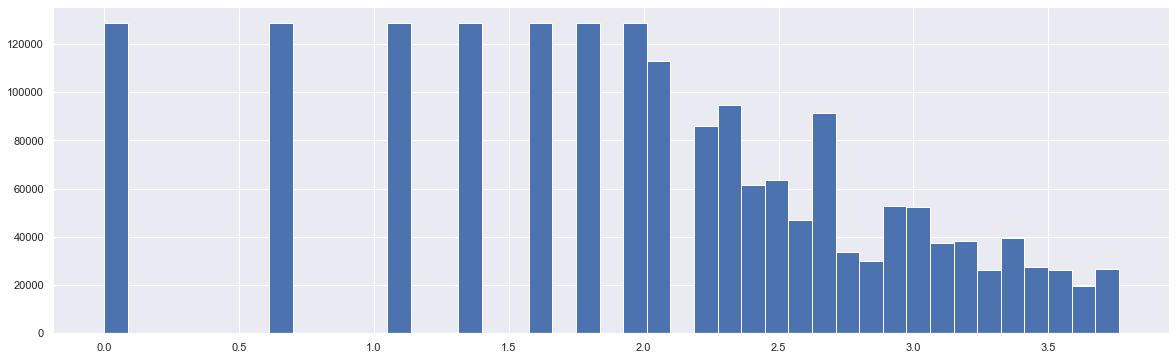

In [36]:
target_dist = np.log(data['JobsRetained'])
plt.figure(figsize=(20, 6))
plt.hist(target_dist, bins=len(set(np.log(data['JobsRetained']))))
plt.show()

In [21]:
np.round(np.mean(target_dist), 0)

2.0

In [22]:
data['log_JobsRetained'] = target_dist

del target_dist

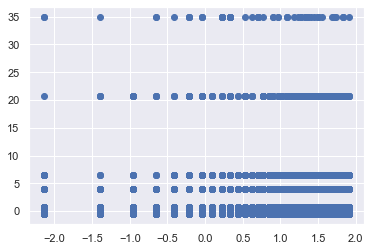

In [33]:
plt.scatter(preprocessing.scale(data['log_JobsRetained']), preprocessing.scale(data['Loan_max']-data['Loan_min']))

In [ ]:
annova_data_scaled=data.copy()
annova_data_scaled['log_JobsRetained'] = preprocessing.scale(annova_data_scaled['log_JobsRetained'])
annova_data_scaled['Loan_min'] = preprocessing.scale(annova_data_scaled['Loan_min'])
annova_data_scaled['Loan_max'] = preprocessing.scale(annova_data_scaled['Loan_max'])

In [ ]:
# Anova
lm_exp = 'log_JobsRetained ~ C(BusinessType)*C(Industry) + C(CD) + C(DateApproved) + C(Gender) + C(NonProfit) + C(RaceEthnicity) + C(State) + C(Veteran)'
lm = ols('log_JobsRetained ~ C(BusinessType) + C(DateApproved) + C(Gender) + C(NonProfit) + C(RaceEthnicity) + C(Veteran)', data=annova_data_scaled, drop_cols=['CD','State', 'Industry' ]).fit()
sm.stats.anova_lm(lm, typ=3)

In [ ]:
# Anova
lm = ols('log_JobsRetained ~ C(Veteran)*C(NonProfit)*C(Gender)', data=annova_data_scaled[['log_JobsRetained', 'Veteran', 'NonProfit', 'Gender']]).fit()
sm.stats.anova_lm(lm, typ=3)

In [ ]:
# Anova
lm = ols('log_JobsRetained ~ C(CD) + C(State)', data=annova_data_scaled[['log_JobsRetained', 'CD', 'State']]).fit()
sm.stats.anova_lm(lm, typ=3)

In [ ]:
# Anova
lm = ols('log_JobsRetained ~ C(BusinessType)*C(Industry)', data=annova_data_scaled[['log_JobsRetained', 'BusinessType', 'Industry']].iloc[:10000]).fit()
sm.stats.anova_lm(lm, typ=3)

In [ ]:
ols('log_JobsRetained ~ Loan_min + Loan_max', data=annova_data_scaled[['log_JobsRetained', 'Loan_min', 'Loan_max']]).fit().summary()

In [ ]:
# Features to consider
feature_cols = ['BusinessType', 'DateApproved', 'Gender',
       'NonProfit', 'RaceEthnicity',
       'State', 'Veteran', 'Industry', 'Loan_min', 'Loan_max']

In [ ]:
scaled_log_JobsRetained = preprocessing.scale(data['log_JobsRetained'])
plt.hist(scaled_log_JobsRetained)

In [ ]:
def encode_scale_feature(df, columns):
    
    df = df[columns]
    
    # One hot encoding
    oh_encoder = preprocessing.OneHotEncoder()
    encoded = oh_encoder.fit_transform(df)
    encoded_cols = oh_encoder.get_feature_names(columns)
                                                                                       
    # Standardization                                                       
    std_scaler = preprocessing.StandardScaler()
    scaled = std_scaler.fit_transform(encoded.toarray())
                   
    df = pd.DataFrame(data=scaled, columns=encoded_cols)
                                                                                       
    return df, (oh_encoder, std_scaler)

In [ ]:
def df_with_important_cat_features(df):
    f, p_val = f_regression(df, scaled_log_JobsRetained)
    df_f_reg = pd.DataFrame() 
    df_f_reg['Column'] = df.columns
    df_f_reg['p_val'] = p_val
    return df[df_f_reg[df_f_reg['p_val'] < 0.05]['Column']]

In [ ]:
df_selected_features = dict()
for feature in feature_cols[:-2]:
    df_feature, feature_transformers = encode_scale_feature(data, [feature])
    df_feature_reduced = df_with_important_cat_features(df_feature)
    df_selected_features[feature] = (df_feature_reduced, feature_transformers)
    print(feature, df_feature_reduced.shape)

In [ ]:
# skb = SelectKBest(f_classif, k='all').fit(df_btype, scaled_log_JobsRetained)
# skb_df = pd.DataFrame()
# skb_df['Column'] = df_btype.columns
# skb_df['Score'] = skb.scores_
# skb_df['p_val'] = skb.pvalues_
# skb_df.sort_values(by=['Score'], ascending=True)

In [ ]:
feature_pca = dict()
for feature in feature_cols[:-2]:
    df_for_PCA = df_selected_features[feature][0]
    pca = PCA(0.90)
    pca.fit(df_for_PCA)
    feature_pca[feature] = pca
    print(feature, df_for_PCA.shape[1], pca.n_components_)

In [ ]:
# feature_pca_2 = dict()
# for feature in feature_cols[:-2]:
#     df_for_PCA = df_selected_features[feature][0]
#     pca = PCA(0.80)
#     pca.fit(df_for_PCA)
#     feature_pca[feature] = pca
#     print(feature, df_for_PCA.shape[1], pca.n_components_)

In [ ]:
# pca_industry = PCA(0.75)
# pca_industry.fit(df_selected_features['Industry'][0])
# feature_pca['Industry'] = pca_industry
# print(feature, df_selected_features['Industry'][0].shape[1], pca_industry.n_components_)

In [ ]:
feature_pca

In [ ]:
# Apply PCA transformations to categoricals
X_reduced_arr = []
for feature in iter(feature_pca):
    if feature != 'Industry':
        transformed_arr = feature_pca[feature].transform(df_selected_features[feature][0])
        if len(X_reduced_arr) == 0:
            X_reduced_arr = transformed_arr
        else:
            X_reduced_arr = np.hstack((transformed_arr, X_reduced_arr))
        print(X_reduced_arr.shape)

In [ ]:
df_reduced_features = pd.DataFrame()
for feature in feature_cols[:-2]:
    if feature != 'Industry':
        df_reduced_features = pd.concat([df_reduced_features, df_selected_features[feature][0]], axis=1)
        print(df_reduced_features.shape)

In [ ]:
loan_scaler = preprocessing.StandardScaler()
scaled_loan_min_max = loan_scaler.fit_transform(data[['Loan_min', 'Loan_max']])
df_loan_min_max = pd.DataFrame(scaled_loan_min_max, columns=['Loan_min', 'Loan_max'])

In [ ]:
X_df = pd.concat([df_reduced_features, df_loan_min_max], axis=1)

In [ ]:
# ANOVA
# for col in ['BusinessType']:
#     print(col)
#     anova_input = list()
#     for each_category in data_dist[col].unique():
# #         print(each_category)
#         # Do f-regression here ##########################
    
    
#         job_ret_count = data_dist['JobsRetained'][data_dist[col] == each_category]
#         anova_input.append(job_ret_count.values)
#     print(stats.f_oneway(*anova_input))
#     break



In [ ]:
np.savez('preprocessed_data', inputs=X_df.values, targets=scaled_log_JobsRetained)

In [ ]:
preprocessed_obj_file = open('preprocessed_obj_pickle', 'ab')
pickle.dump({
    'df_selected_features': df_selected_features,
    'feature_pca': feature_pca,
    'scaled_loan_min_max': scaled_loan_min_max,
    'scaled_log_JobsRetained': scaled_log_JobsRetained
})
preprocessed_obj_file.close()

In [ ]:
np.save

In [ ]:
import dill
dill.dump_session('Preprocessing-session_env.pkl')
# dill.load_session('EDA and Preprocessing-Copy2_env.db')